<a href="https://colab.research.google.com/github/da2985/e6885-adnet/blob/main/reinforce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports & Starting Configs

Please use the following two lines to load from Google Drive

If your file is not there, upload it to https://drive.google.com/drive/folders/1tsPKyB2E1nW8Qw--kZ9GaeGW2u2-XoV6?usp=sharing

In [32]:
# This must be run within a Google Colab environment 
from google.colab import drive  
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import sys
import os

sys.path.append('/content/gdrive/EE6885')

os.chdir("/content/gdrive/My Drive/EE6885")

In [3]:
!ls adnet_datasets/OTB

Basketball  Bolt  Car4	    ClifBar  Doll      Fish    MotorRolling
Bird2	    Boy   CarDark   Crowds   Dudek     Human2  Skater
BlurCar3    Car1  CarScale  Deer     FaceOcc2  Human6  Skating1


In [4]:
pip install hdf5storage tensorflow-addons

     |████████████████████████████████| 53 kB 1.2 MB/s 
     |████████████████████████████████| 1.1 MB 10.3 MB/s 


In [5]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

import tensorflow_probability as tfp
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import regularizers
import tensorflow.experimental.numpy as tnp

import cv2
import glob
import hdf5storage
import math
import random
import re

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import scipy.io as sio

import linecache

from typing import Dict, List, Tuple
from operator import add
import copy

from numpy.random import seed
from datetime import datetime

In [6]:
 %load_ext autoreload 
 %autoreload 2

# Configurations

In [7]:
#@markdown Network configurations
LEARNING_RATE = 1e-4 #@param {type:"number"}
GOAL_IOU = 0.7 #@param {type:"number"}

# The length of the action buffer
L = 10 #@param {type:"number"}
# Max Trajectory Length 
MAX_TRAJECTORY_LENGTH =  5#@param {type:"number"}
POLICY_TYPE = "stochastic" #@param ["deterministic", "stochastic"] {type:"string"}
DROPOUT_4 = 0.5 #@param {type:"number"}
DROPOUT_5 = 0.5 #@param {type:"number"}
N_EPOCHS =  300#@param {type:"number"}

# Number of retries to collect sequence loss sum (to reduce variance)
N_RETRIES =   1#@param {type:"number"}

# Randomizes the order in which frames are trained on from a video clip
RANDOMIZE_TRAINING = False #@param {type:"boolean"}

# The paper uses sum. I thought avg would help address giant swings, but the training was taking way too long
# with negligible updates
GRAD_ACCUM_SCHEME = "sum" #@param ["avg", "sum"] {type:"string"}

# Use to avoid overly long trajectories. 
# During trajectory collection, we were not receiving 
# enough positvie signals
PREMATURE_BREAK = False #@param {type:"boolean"}


#@markdown ---
#@markdown Loss/Reward Constants
# This is a probability offset for adding noise since log(P(a|s)=1)=0
PROB_OFFSET = 1e-5 #@param {type:"number"} 
# This is the discount factor
GAMMA = 1 #@param {type:"number"}

# The paper uses final_bbox where only the final bounding box placement is accounted
# in reward calculation. individ_bbox individually assign rewards per each bounding box.
REWARD_SCHEME = "final_bbox" #@param ["final_bbox", "individ_bbox"] {type:"string"}

#@markdown ---
#@markdown Bounding Box/Patch Constants (probably avoid touching)
ALPHA = 0.03 #@param {type:"number"}
MIN_WINDOW_SIZE = 10 #@param {type:"number"}
PATCH_X = 112 #@param {type:"number"}
PATCH_Y = 112 #@param {type:"number"}
N_CHANNELS = 3 #@param {type:"number"}

#@markdown ---
RANDOM_SEED = 6885







In [7]:
seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

DATASET_PATH = "adnet_datasets/vot2019/*" #@param {type:"string"}
ALL_DATASETS_LIST = glob.glob(DATASET_PATH)

### Successful Configurations (Minimize Me Please)

## Model Definitions

In [8]:
class ADNET(tf.keras.Model):

    ACTION_DIM = 11
    K = 10
    CONF_SCORE_DIM = 2

    def __init__(self):
        super(ADNET, self).__init__()

        self.action_history = tf.keras.layers.Input(shape = (1,1, ADNET.ACTION_DIM * ADNET.K))

        self.conv1 = tf.keras.layers.Conv2D(filters = 96, kernel_size = (7, 7), strides = (2, 2), padding = 'VALID', activation = 'relu', name = 'conv_1')
        self.max1  = tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides = (1, 1), padding = 'VALID')
        self.conv2 = tf.keras.layers.Conv2D(filters = 256, kernel_size = (5, 5), strides = (2, 2), padding = 'VALID', activation = 'relu', name = 'conv_2')
        self.max2  = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides = (2, 2), padding = 'VALID')
        self.conv3 = tf.keras.layers.Conv2D(filters = 512, kernel_size = (3, 3), strides = (2, 2), padding = 'VALID', activation = 'relu', name = 'conv_3')
        self.max3  = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides = (1, 1), padding = 'VALID')
        
        self.fc1 = tf.keras.layers.Conv2D(filters = 512, kernel_size = (3, 3), padding = 'VALID', activation = 'relu', name = 'fc1')
        self.fc2 = tf.keras.layers.Conv2D(filters = 512, kernel_size = (1,1), padding = 'VALID', activation = 'relu', name = 'fc2')
        self.fc3 = tf.keras.layers.Conv2D(filters = 11, kernel_size = (1,1), padding = 'VALID', name = 'fc3',activation="softmax")
        self.fc4 = tf.keras.layers.Conv2D(filters = 2, kernel_size = (1,1), padding = 'VALID', name = 'fc4',activation="softmax")

        # TODO: ADD A SEED
        self.dropout1=tf.keras.layers.Dropout(DROPOUT_4)
        self.dropout2=tf.keras.layers.Dropout(DROPOUT_5)
        

    def build(self):
      super(ADNET, self).build((None, 112, 112, 3))
      self.action_history = np.zeros(shape = (1,1,1,110))


    def call(self, input_tensor, training=False):
        x = self.conv1(input_tensor)
        x = self.max1(x)
        x = self.conv2(x)
        x = self.max2(x)
        x = self.conv3(x)
        x = self.max3(x)

        x = self.fc1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        x = tf.keras.layers.Concatenate(axis=-1)([x, self.action_history])
        action = self.fc3(x)
        confidence = self.fc4(x)
        return [action, confidence]


    def compile(self, optimizer):
   		super().compile(optimizer, loss={
         'output_1':tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
         'output_2': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
         })
     
    def getEmbedding(self,input_tensor):
        x = self.conv1(input_tensor)
        x = self.max1(x)
        x = self.conv2(x)
        x = self.max2(x)
        x = self.conv3(x)
        x = self.max3(x)
        return tf.reshape(x,(-1,))

    def getFC1(self,input_tensor):
        x = self.conv1(input_tensor)
        x = self.max1(x)
        x = self.conv2(x)
        x = self.max2(x)
        x = self.conv3(x)
        x = self.max3(x)
        x = self.fc1(x)
        return x

    def setActionHistory(self, action_history):
      self.action_history = action_history.reshape(
          (1, 1, 1, ADNET.ACTION_DIM * ADNET.K))

    def updateActionHistory(self, a: int=8) -> tnp.ndarray:
      '''
      Left-to-right FIFO queue of actions
      '''
      ah = np.array(self.action_history).flatten()
      ah[ADNET.ACTION_DIM:] = ah[:-ADNET.ACTION_DIM]
      ah[:ADNET.ACTION_DIM] = 0 
      ah[a] = 1
      self.setActionHistory(ah)
      return ah

    def clearActionHistory(self):
      self.action_history = tf.zeros((1, 1, 1, ADNET.ACTION_DIM * ADNET.K))

    def getPrettyActionHistory(self):
      action_hist = tf.reshape(model.action_history, [-1])
      sbuffer = "["
      for i, x in enumerate(action_hist):
        if i > 0 and i % model.ACTION_DIM == 0:
          sbuffer+= "\x1b[35m,\x1b[0m"
        if x == 1:
          sbuffer += "\x1b[35m{0}\x1b[0m".format(int(x))
        else:
          sbuffer += "{0}".format(int(x))
      sbuffer += "]"
      return sbuffer 


    def debugModelSummary(self):
      '''
      call model.debugModelSummary().summary() to get around the inconvenience 
      from model.summary() returning 'multiple' for each layer's output shape
      '''
      dummyInput = tf.keras.layers.Input(shape = (112,112,3))
      return tf.keras.Model(inputs=[dummyInput], outputs = self.call(dummyInput))

def setWeights(model, weights, weights2):
  model.layers[0].set_weights([weights2["conv1f"],tf.reshape(weights2["conv1b"],(96,))])
  model.layers[2].set_weights([weights2["conv2f"],tf.reshape(weights2["conv2b"],(256,))])
  model.layers[4].set_weights([weights2["conv3f"],tf.reshape(weights2["conv3b"],(512,))])
  
  model.layers[6].set_weights([weights["fc4f"],tf.reshape(weights["fc4b"],(512,))])
  model.layers[7].set_weights([weights["fc5f"],tf.reshape(weights["fc5b"],(512,))])
  model.layers[8].set_weights([weights["fc6_1f"],tf.zeros(11)])
  model.layers[9].set_weights([weights["fc6_2f"],tf.zeros(2)])
  
  return model

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Helper Functions

### Plotting & Debugging

In [9]:
def get_ground_truths(ground_truth_file: str) -> np.array:
  '''
  Use me to convert a ground_truth_file to a numpy array
  '''
  with open(ground_truth_file) as f:
    ground_truths = f.readlines()
    to_nparray = lambda s: np.array(re.findall('\d+', s), dtype=int)
    truths = list(map(to_nparray, ground_truths))
    return np.asarray(truths)
  return None

def plotNpImageBBox(img: np.array, bbox: np.array) -> np.array:
  '''
  Plots the bounding box on an image and returns the bounding box
  '''
  fig, ax = plt.subplots()
  x, y, w, h = bbox
  rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
  ax.add_patch(rect)
  plt.imshow(img)
  return bbox

def plotNpImageBBoxes(img: np.array, src_bbox: np.array, target_bbox: np.array, 
                      pred_bbox: np.array) -> np.array:
  '''
  Plots the bounding boxes on an image and returns the bounding box
  '''
  fig, ax = plt.subplots()
  x1, y1, w1, h1 = src_bbox
  x2, y2, w2, h2 = target_bbox
  x3, y3, w3, h3 = pred_bbox
  rect1 = patches.Rectangle((x1, y1), w1, h1, linewidth=1, edgecolor='b', facecolor='none')
  rect2 = patches.Rectangle((x2, y2), w2, h2, linewidth=1, edgecolor='g', facecolor='none')
  rect3 = patches.Rectangle((x3, y3), w3, h3, linewidth=1, edgecolor='r', facecolor='none')
  ax.add_patch(rect1)
  ax.add_patch(rect2)
  ax.add_patch(rect3)
  plt.imshow(img)
  return pred_bbox  

def plotImageBBox(img: str, bbox: np.array) -> np.array:
  '''
  Plots the bounding box on an image (from given filepath) and returns the 
  bounding box
  '''
  img = cv2.imread(img)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plotNpImageBBox(img, bbox)
  return bbox

def plotDatasetImageBBox(dataset: str, frame_no: int) -> Tuple[np.array, int]:
  '''
  Plot an image's bounding box. Returns the ground truth and frame number.
  WORKS FOR OTB100
  '''
  imgs = sorted(glob.glob("{0}/img/*".format(dataset)))
  gt = get_ground_truths("{0}/groundtruth_rect.txt".format(dataset))
  plotImageBBox(imgs[frame_no], gt[frame_no])
  return gt[frame_no], frame_no


# print(plotDatasetImageBBox("adnet_datasets/OTB/Basketball", 50)[0])
print(plotDatasetImageBBox("adnet_datasets/OTB/BlurBody", 10)[0])

FileNotFoundError: ignored

### Movement

In [10]:
STOP_ACTION_INDEX = 8

def getFrame(f_path: str) -> np.array:
  print("Frame path: {0}".format(f_path))
  img = cv2.imread(f_path)
  return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


def calculate_IOU(bbox1: np.array, bbox2: np.array):
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2
           
    i_x1 = max(x1, x2)
    i_y1 = max(y1, y2)
    i_x2 = min(x1 + w1, x2 + w2)
    i_y2 = min(y1 + h1, y2 + h2)
    if i_x1 >= i_x2 or i_y1 >= i_y2:
      return 0.0

    intersection_area = (i_x2 - i_x1) * (i_y2 - i_y1)
    box1_area = w1 * h1
    box2_area = w2 * h2
    
    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    return iou


def move(image: np.array, bbox: np.array, action: str, 
         stride_magnitude: int=1) -> np.array:
  '''
  Returns the new bounding box after taking an action: 
  {"left", "right", "up", "down"}. Use stride to indicate the step size.
  '''
  if action not in set(["left", "right", "up", "down"]):
    raise RuntimeError("Invalid action taken :(") 
  
  x, y, w, h = bbox
  if action in set(["left", "right"]):
    step = max(1, int(ALPHA * w)) * stride_magnitude * (-1 if action=="left" else 1)
    x = min(max(0, int(x + step)), int(image.shape[1] - w - 1)) 
  else:
    step = max(1, int(ALPHA * h)) * stride_magnitude * (-1 if action=="up" else 1)
    y = min(max(0, int(y + step)), int(image.shape[0] - h - 1)) 

  return np.array([x, y, w, h])


def scale(image: np.array, bbox: np.array, scaleUp: bool):
  x, y, w, h = bbox
  deltaW, deltaH = max(2, ALPHA * w), max(2, ALPHA * h)
  if not scaleUp: 
    deltaW *= -1
    deltaH *= -1
  nw = min(image.shape[1], max(MIN_WINDOW_SIZE, int(w + deltaW))) 
  nh = min(image.shape[0], max(MIN_WINDOW_SIZE, int(h + deltaH)))
  

  x = max(0, min(int(x - deltaW / 2), int(image.shape[1] - w - 1)))
  y = max(0, min(int(y - deltaH / 2), int(image.shape[0] - h - 1)))
  return np.array([x, y, nw, nh])


def selectAction(img: np.array, bbox: np.array, index: int): 
  if index == 0 :
    bbox = move(img, bbox, "left")
  elif index == 1 :
    bbox = move(img, bbox, "left", stride_magnitude=2)
  elif index == 2 :
    bbox = move(img, bbox, "right")
  elif index == 3 :
    bbox = move(img, bbox, "right", stride_magnitude=2)  
  elif index == 4 :
    bbox = move(img, bbox, "up")  
  elif index == 5 :
    bbox = move(img, bbox, "up", stride_magnitude=2)
  elif index == 6 :
    bbox = move(img, bbox, "down")
  elif index == 7 :
    bbox = move(img, bbox, "down", stride_magnitude=2)
  elif index == 8:
    bbox = bbox
  elif index == 9 :
    bbox = scale(img, bbox, False)     
  elif index == 10 :
    bbox = scale(img, bbox, True)    
  else:
    raise ValueError("Invalid action provided: {0}".format(index))

  x, y, w, h = bbox
  # some of the data is just invalid :/
  # assert 0 <= x <= img.shape[1] - w, "x:{0}, w:{1} is out of bounds: [0, {2}]".format(x, w, img.shape[1])
  # assert 0 <= y <= img.shape[0] - h, "y:{0}, h:{1} is out of bounds: [0, {2}]".format(y, h, img.shape[0])
  # assert MIN_WINDOW_SIZE <= w <= img.shape[1], "w:{0}, is invalid".format(w)
  # assert MIN_WINDOW_SIZE <= h <= img.shape[0], "h:{0} is invalid".format(h)
  return index, bbox


def human_readable_action(index: int) -> str:
  '''
  Map action numbers to human readable strings
  '''
  def _get_action(index:int) -> str:
    if index == 0:
      return "left"
    elif index == 1:
      return "2x left"
    elif index == 2:
      return "right"
    elif index == 3:
      return "2x right"
    elif index == 4:
      return "up"
    elif index == 5:
      return "2x up"
    elif index == 6:
      return "down"
    elif index == 7:
      return "2x down"
    elif index == 8:
      return "stop"
    elif index == 9:
      return "scale down"
    elif index == 10 :
      return "scale up"
  return _get_action(index).upper()


def getAction(img: np.array, bbox: np.array, action_probs: np.array):  
  a = -1
  if POLICY_TYPE == "deterministic":
    a = tf.math.argmax(action_probs)
  else:
    action_probs = np.array(action_probs) + PROB_OFFSET
    action_probs /= action_probs.sum()
  
    a = np.random.choice(np.arange(len(action_probs)), p=action_probs)
  return selectAction(img, bbox, a)


def isStop(action: int):
  return action == STOP_ACTION_INDEX


# REINFORCE Loop

### Trajectory Loss Function

TODO: investigate adding https://www.analyticsvidhya.com/blog/2020/11/baseline-for-policy-gradients/
Or rather https://arxiv.org/pdf/1301.2315.pdf

### Tracking Procedure

* This function collects trajectories either via argmax deterministic policy or sampling from a stochastic policy

### Single Training Loop

### Epoch Training Loops

# Training Procedure

In [11]:
%reload_ext autoreload
def getPatch(img: np.array, bbox: np.array) -> tf.Tensor:
  def _patch(img: np.array, bbox: np.array) -> np.array:
    x, y, w, h, = bbox
    return img[y : (y + h), x : (x + w)]
      
  patch = tf.image.resize(_patch(img, bbox), [PATCH_X, PATCH_Y])
  return tf.reshape(patch, (1, PATCH_X, PATCH_Y, N_CHANNELS))

### Save Weights for Reproducibility

### Observations

* The paper sums all sequence rewards. However, we found this to produce too much variance. We reduce_mean instead to address this. If we had

# Prediction

In [12]:
def predict(model: tf.keras.Model,img: np.array,bbox: np.array) -> np.array:
  ACTION_DIM=11
  seen_bboxes = set()
  for t in range(MAX_TRAJECTORY_LENGTH):
    #model.setActionHistory(action_hist.reshape((1, 1, 1, ACTION_DIM * K)))
    #model.setActionHistory(action_hist.reshape((1,ACTION_DIM * K))) ### For ADNET_v2
    patch = getPatch(img, bbox)
    a_prob, score = model(patch)
    maxaction = np.argmax(a_prob)
    a, bbox = selectAction(np.array(img), bbox, maxaction)
    model.updateActionHistory(a)
    if isStop(a) or tuple(bbox) in seen_bboxes:
      break 
   # seen_bboxes.add(tuple(bbox))
  return bbox

In [13]:
def plotNpImageBBoxGT(img: np.array, bbox: np.array,gbbox: np.array) -> np.array:
  '''
  Plots the bounding box on an image and returns the bounding box
  '''
  fig, ax = plt.subplots()
  x_pre,y_pre, w_pre, h_pre = bbox
  x_gr,y_gr, w_gr, h_gr = gbbox
  predicted_rect = patches.Rectangle((x_pre, y_pre), w_pre, h_pre, linewidth=1, edgecolor='r', facecolor='none')
  gt_rect = patches.Rectangle((x_gr, y_gr), w_gr, h_gr, linewidth=1, edgecolor='b', facecolor='none')
  ax.add_patch(predicted_rect)
  ax.add_patch(gt_rect)
  plt.imshow(img)
  return bbox

In [14]:
def standardize_bbox(img: np.array, bbox: np.array):
  '''
  Refits the bounding box to ensure that it is valid. X and Y get clipped first.
  Assumes reasonable bounding boxes and solely for the bad data we found in
  our ground truth dataset
  '''
  x, y, w, h = bbox
  nx, ny, nw, nh = bbox

  is_invalid = False
  import pdb
  # pdb.set_trace()
  if x < 0 or x + w >= img.shape[1]:
    w = np.clip(w, MIN_WINDOW_SIZE, img.shape[1])
    # clip whichever keeps the most area    
    x1 = np.clip(x, 0, img.shape[1] - 1)
    w1 = np.clip(w, MIN_WINDOW_SIZE, img.shape[1] - x1)
    x2 = np.clip(x, 0, img.shape[1] - w)
    w2 = np.clip(w, MIN_WINDOW_SIZE, img.shape[1])
    nx, nw = (x1, w1) if x1 + w1 > x2 + w2 else (x2, w2)
    is_invalid = True

  if y < 0 or y + h >= img.shape[0]:
    h = np.clip(h, MIN_WINDOW_SIZE, img.shape[0])
    # clip whichever keeps the most area
    y1 = np.clip(y, 0, img.shape[0] - 1)
    h1 = np.clip(h, MIN_WINDOW_SIZE, img.shape[0] - y1)
    y2 = np.clip(y, 0, img.shape[0] - h)
    h2 = np.clip(h, MIN_WINDOW_SIZE, img.shape[0])
    ny, nh = (y1, h1) if y1 + h1 > y2 + h2 else (y2, h2)
    is_invalid = True
  
  stdzd_bbox = np.array([nx, ny, nw, nh])
  if is_invalid: 
    print("WARNING: Bounding box: {0} had to be standardized to {1}".format(bbox, stdzd_bbox))
  return stdzd_bbox

In [15]:
  test_list = glob.glob("adnet_datasets/Test/*")
print(test_list)

['adnet_datasets/Test/Biker', 'adnet_datasets/Test/Bird1', 'adnet_datasets/Test/BlurBody', 'adnet_datasets/Test/BlurCar1', 'adnet_datasets/Test/BlurCar2', 'adnet_datasets/Test/BlurCar4', 'adnet_datasets/Test/BlurFace', 'adnet_datasets/Test/Board', 'adnet_datasets/Test/Box', 'adnet_datasets/Test/Bolt2', 'adnet_datasets/Test/Car2', 'adnet_datasets/Test/Car24', 'adnet_datasets/Test/Coke', 'adnet_datasets/Test/Coupon', 'adnet_datasets/Test/Couple', 'adnet_datasets/Test/Crossing', 'adnet_datasets/Test/Dancer2', 'adnet_datasets/Test/Dancer', 'adnet_datasets/Test/David2', 'adnet_datasets/Test/Dog1', 'adnet_datasets/Test/DragonBaby', 'adnet_datasets/Test/David3', 'adnet_datasets/Test/Dog', 'adnet_datasets/Test/FaceOcc1', 'adnet_datasets/Test/FleetFace', 'adnet_datasets/Test/Football1', 'adnet_datasets/Test/Freeman1', 'adnet_datasets/Test/Girl', 'adnet_datasets/Test/Girl2', 'adnet_datasets/Test/Gym', 'adnet_datasets/Test/Human5', 'adnet_datasets/Test/Human4', 'adnet_datasets/Test/Human3', 'adne

In [33]:
import time
#OPE TEST
#test videos similar to kaans training videos : BlurCar1-3-4 , Car1, Car2 , FaceOcc1, Girl , Human ,Walking
def test_metrics( model: tf.keras.Model, model2:tf.keras.Model , model3:tf.keras.Model ):
    all_boxes = []
    all_boxes2 = []
    all_boxes3 = []
    all_gt = []
    time_perframe_for_each_video =[]
    test_list = glob.glob("adnet_datasets/Test/*")
    #for it in range(5): activate for TRE
    for  i in [2,3,10,11]:  # start with 1
      dataset = test_list[i]
      print(dataset)
      model.clearActionHistory()
      gt = get_ground_truths("%s/groundtruth_rect.txt" % dataset)     
      all_gt.append(gt)
      frames = sorted(glob.glob(os.path.join('%s/img' % dataset, '*.jpg')))
      number_of_frames = len(frames)
      #start_frame = random.randint(0, number_of_frames) ACTIVATE FOR TRE
      start_frame = 1
      boxes_m1 =[]
      boxes_m2 = []
      boxes_m3 = []
      time_perframe = []
      predicted_box = gt[0]
      predicted_box2 = gt[0]
      predicted_box3 = gt[0]
      start = time.time()
      for f in range(100):#len(frames) - start_frame):
        img = cv2.imread(frames[f + start_frame])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        predicted_box=  predict(model,img,predicted_box)
        #predicted_box =  standardize_bbox(img, predicted_box)

        #predicted_box2 = predict(model, img,predicted_box2) if we want to compare 2 models
        #predicted_box2 =  standardize_bbox(img, predicted_box2) if you want to compare at the same time two models uncomment
        #predicted_box3 = predict(model, img,predicted_box3) if we want to compare 3 models
        #predicted_box3 =  standardize_bbox(img, predicted_box3) if you want to compare at the same time three models uncomment
        boxes_m1.append(predicted_box)
        #boxes_m2.append(predicted_box2)
        #boxes_m3.append(predicted_box3)

      end = time.time()
      time_perframe = (start-end)/len(frames)
      all_boxes.append(boxes_m1)
      #all_boxes2.append(boxes_m2)
      #all_boxes3.append(boxes_m2)
      time_perframe_for_each_video.append(time_perframe)
    return all_boxes, all_boxes2,all_boxes3, all_gt , time_perframe_for_each_video # if yu want to compare two models add here all_boxes2

adnet_model = ADNET()
adnet_model.build()
#WEIGHTS_PATH = "checkpoints/derek-19-12-2021_012730.h5"
#weights = hdf5storage.loadmat(YIFAN_WEIGHTS_PATH)
adnet_model.load_weights("/content/gdrive/My Drive/EE6886/my_model_sl-cR")
all_boxes1 ,all_boxes2, all_boxes3, all_gt , time_perframe_for_each_video = test_metrics(adnet_model , adnet_model,adnet_model)
print (all_boxes1)
print(all_gt)

adnet_datasets/Test/BlurBody
adnet_datasets/Test/BlurCar1
adnet_datasets/Test/Car2
adnet_datasets/Test/Car24
[[array([400,  66,  87, 319]), array([400, 156,  87, 319]), array([400, 160,  87, 319]), array([400, 160,  87, 319]), array([400, 160,  87, 319]), array([400, 160,  87, 319]), array([400,  88,  87, 319]), array([414,  88,  87, 319]), array([404,  88,  87, 319]), array([411, 100,  78, 290]), array([421, 100,  78, 290]), array([417,  68,  78, 290]), array([437,  68,  78, 290]), array([453,  60,  78, 290]), array([453,  52,  78, 290]), array([457,  52,  78, 290]), array([477,  52,  78, 290]), array([493,  44,  78, 290]), array([477,  52,  78, 290]), array([489,  52,  78, 290]), array([497,  44,  78, 290]), array([503,  20,  78, 290]), array([513,  28,  78, 290]), array([525,  44,  78, 290]), array([529,  44,  78, 290]), array([533,  44,  78, 290]), array([541,  52,  78, 290]), array([539,  44,  78, 290]), array([547,  44,  78, 290]), array([549,  39,  80, 298]), array([553,  39,  8

In [34]:
from scipy.spatial.kdtree import distance_matrix
from scipy.spatial import distance

def calculate_precision(trackerresults, groundtruth, threshold):
  """
  Input: List of bounding box results from tracker, ground truth file, location error threshold
  Output: Returns the percentage of points whose center point has a euclidean distance that is less than the
          threshold away from the groudtruth
  x, y, w, h = bbox
  """
   # Iterate through each frame, find the center for each frame and calculate the 
   # euclidean distance between the tracker and groundtruth
  result = 0
  pts = 0
  for bbox1, bbox2 in zip(trackerresults, groundtruth):
    #X and y indicate top left corner
    x1, y1, w1, h1 = bbox1
    center1 = [x1-.5*w1, y1-.5*h1]
    x2, y2, w2, h2 = bbox2
    center2 = [x2-.5*w2, y2-.5*h2]
    dist = distance.euclidean(center1, center2)
    #print("DICT", dist)
    pts += 1
    if dist <= threshold:
      result += 1

  result = result/pts


  return result



In [27]:
import matplotlib as plt
import decimal as d

def graph_precision_plot(trackerresults, groundtruth):
  #1: Iterate through every threshold
  precisions = []# np.zeros((50,), dtype=int) 
  thresholds = np.arange(0, 50, 1)
  i=0
  for threshold in thresholds: #(Threshold in pixels)
  #2: Iterate through every video 
    num_vids = float(0)
    precision = 0
    for bboxes1, bboxes2 in zip(trackerresults, groundtruth):
      temp = calculate_precision(bboxes1,bboxes2,threshold)
      precision = precision + temp
      num_vids += 1.0000000000
    #print(type(precision), type(num_vids))
    precisions.append(float(precision)/float(num_vids))
    i+=1
    #print(precision,precisions[threshold])


  #3: Graph average percision of all videos vs threshold

  # plotting the points
  plt.pyplot.plot(thresholds, precisions)
 
  # naming the x axis
  plt.pyplot.xlabel('Location Error Threshold')
  # naming the y axis
  plt.pyplot.ylabel('Precision')
 
  # giving a title to my graph
  plt.pyplot.title('Precision Plots of OPE')
 
  # function to show the plot
  plt.pyplot.savefig('Precision.png')
  plt.pyplot.show()


def graph_success_plot(trackerresults, groundtruth):
  #1 Iterate through overlap threshold
  successes = []
  thresholds = np.arange(0, 1, .01)
  i = 0
  for threshold in thresholds: #(Threshold in pixels)

  #2 Iterate through every video

    num_vids = 0
    success = 0
    for bboxes1, bboxes2 in zip(trackerresults, groundtruth): 
      success += calculate_success(bboxes1,bboxes2,threshold)
      num_vids += 1

    successes.append(success/num_vids)
    i +=1
  #3 Graph average success vs threshold

  # plotting the points
  print(successes)
  plt.pyplot.plot(thresholds, successes)
 
  # naming the x axis
  plt.pyplot.xlabel('Overlap Threshold')
  # naming the y axis
  plt.pyplot.ylabel('Success Rate')
 
  # giving a title to my graph
  plt.pyplot.title('Success Plots of OPE')
 
  # function to show the plot
  plt.pyplot.show()

In [23]:
import numpy as np
def calculate_IOU(bbox1: np.array, bbox2: np.array):
    """
    input is single bounding box for tracker and groundtruth
    output is IOU
    """
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2
    #print(bbox1)
    #print(bbox2)      
    i_x1 = max(x1, x2)
    i_y1 = max(y1, y2)
    i_x2 = min(x1 + w1, x2 + w2)
    i_y2 = min(y1 + h1, y2 + h2)
    if i_x1 >= i_x2 or i_y1 >= i_y2:
      #print("fck")
      return 0.0

    intersection_area = (i_x2 - i_x1) * (i_y2 - i_y1)
    box1_area = w1 * h1
    box2_area = w2 * h2
    
    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    return iou


def calculate_success(trackerresults, groundtruth, threshold):

  result = 0
  pts = 0 
  for bbox1, bbox2 in zip(trackerresults, groundtruth):
    IOU = calculate_IOU(bbox1, bbox2)
 
    pts += 1
    if IOU > threshold:
      result += 1

  result = result/pts

  return result


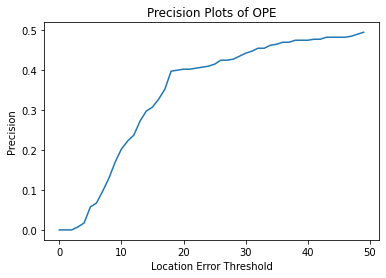

[0.7949999999999999, 0.7949999999999999, 0.79, 0.7875, 0.7875, 0.785, 0.7825, 0.7675000000000001, 0.73, 0.7025, 0.665, 0.635, 0.5975, 0.5875, 0.565, 0.5525, 0.5475, 0.535, 0.5325, 0.525, 0.52, 0.515, 0.51, 0.505, 0.5, 0.4975, 0.4925, 0.4925, 0.4875, 0.485, 0.485, 0.47, 0.46499999999999997, 0.4625, 0.44499999999999995, 0.4425, 0.435, 0.4225, 0.4175, 0.40499999999999997, 0.39749999999999996, 0.395, 0.39, 0.38, 0.37, 0.3575, 0.345, 0.31999999999999995, 0.31999999999999995, 0.31499999999999995, 0.2825, 0.28, 0.275, 0.2675, 0.255, 0.2275, 0.21750000000000003, 0.21500000000000002, 0.1975, 0.1875, 0.1825, 0.18, 0.18, 0.1725, 0.1725, 0.16999999999999998, 0.1675, 0.1625, 0.15250000000000002, 0.14, 0.1325, 0.1325, 0.12, 0.115, 0.0625, 0.0425, 0.0225, 0.0225, 0.0125, 0.01, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.0075, 0.005, 0.005, 0.005, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


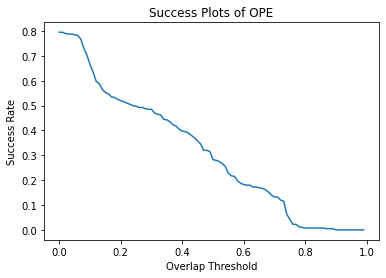

In [35]:
graph_precision_plot(all_boxes1, all_gt)

graph_success_plot(all_boxes1, all_gt)



[ 0.07282026 -0.08901678  0.08613496  0.04703538  0.07904872  0.09412998
 -0.00701348 -0.05435824  0.06835599  0.01236562  0.04766954]
10


Text(0.5, 1.0, 'Squared weights for each action of the action vector')

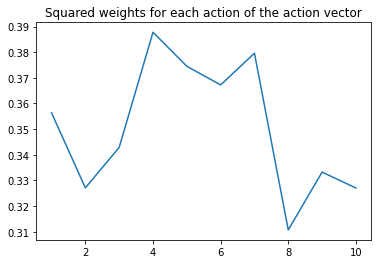

In [36]:
from tensorflow import keras
##adnet_model = ADNET()
#adnet_model.build()
#WEIGHTS_PATH = "checkpoints/derek-19-12-2021_012730.h5"
#weights = hdf5storage.loadmat(YIFAN_WEIGHTS_PATH)
#adnet_model.load_weights(WEIGHTS_PATH)
last_layer = adnet_model.layers[8].get_weights()[0]
print(last_layer[0][0][621])
w =[]
#QUESTION ABOUT THIS ONE
#take last 110x11 values of the last layer weights because the other 512 come from the concatanation should it be the last or the first ones?
#every 10 lists of 11 we are moving back one action...
for i in range(512,622-10,10):
  sum=0
  for j in range(10):
    squared_numbers = [number ** 2 for number in last_layer[0][0][i+j]]
    sum += np.sum(squared_numbers)
  w.append(sum)

print(len(w))
import seaborn as sns
import matplotlib.pyplot as plt

x = range(1,11)

plot = sns.lineplot (x=x , y=w)
#should be high in the beggining low at the end

plot.set_title("Squared weights for each action of the action vector")






6842
6842
[-0.05160823 -0.09715641  0.03502798  0.05718637  0.01165083 -0.00192319
  0.0566667   0.0743661  -0.01312026 -0.03310439  0.01575821]


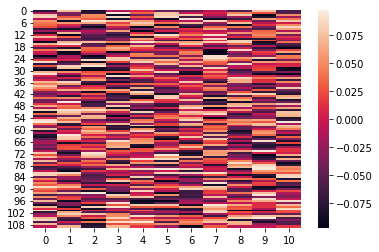

In [54]:
#heatmap of action weight vector should have more intense colors towards the beggining
print(last_layer[0][0].size)
last_layer2 = adnet_model.layers[8].get_weights()[0]
print(last_layer2.size)
l = last_layer2[0][0]
print(l[0])
df = []
for i in range(512,622):
  df.append(l[i])

ax = sns.heatmap(df)

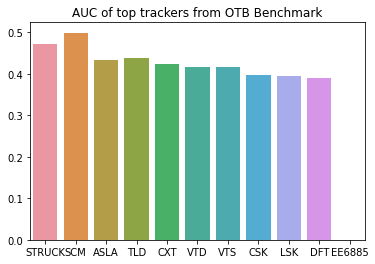

In [ ]:
# to create AUC PLOT IF YOU WANT ADD TRACKERS NOT IN BENCHMARK WITH GREATER AUCs as well https://paperswithcode.com/sota/visual-object-tracking-on-otb-2013
x = [
'STRUCK',
'SCM'	,
'ASLA',
'TLD'	,
'CXT'	,

'VTD',
'VTS'	,
'CSK',
'LSK' ,
'DFT'	,

'EE6885']

y = [0.473, 0.499, 0.434, 0.437, 0.424,0.416,0.416, 0.398,0.395,0.389,0]
plot2 = sns.barplot(x=x, y=y)
plot2.set_title("AUC of top trackers from OTB Benchmark")
plt.savefig('AUC.png')




In [ ]:
#draw multiple curves
import matplotlib.pyplot as plt
import decimal as d

def graph_precision_plot(model_results, model_gts,num_models):
  for model in range(num_models):
    trackerresults, groundtruth = model_results[model], model_gts[model]
    #1: Iterate through every threshold
    precisions = []# np.zeros((50,), dtype=int) 
    thresholds = np.arange(0, 50, 1)
    i=0
    for threshold in thresholds: #(Threshold in pixels)
    #2: Iterate through every video 
      num_vids = float(0)
      precision = 0
      for bboxes1, bboxes2 in zip(trackerresults, groundtruth):
        temp = calculate_precision(bboxes1,bboxes2,threshold)
        precision = precision + temp
        num_vids += 1.0000000000
      #print(type(precision), type(num_vids))
      precisions.append(float(precision)/float(num_vids))
      i+=1
      #print(precision,precisions[threshold])


    #3: Graph average percision of all videos vs threshold

    # plotting the points
    plt.plot(thresholds, precisions)
  
    # naming the x axis
    plt.xlabel('Location Error Threshold')
    # naming the y axis
    plt.ylabel('Precision')
  
    # giving a title to my graph
    plt.title('Precision Plots of OPE')
  
  # function to show the plot
  plt.savefig('Precision.png')
  plt.show()


def graph_success_plot(model_results, model_gts,num_models):
  for model in range(num_models):
    trackerresults, groundtruth = model_results[model], model_gts[model]
    #1 Iterate through overlap threshold
    successes = np.zeros((100,), dtype=int) 
    thresholds = np.arange(0, 1, .01)
    i = 0
    for threshold in thresholds: #(Threshold in pixels)

    #2 Iterate through every video

      num_vids = 0
      success = 0
      for bboxes1, bboxes2 in zip(trackerresults, groundtruth): 
        success += calculate_success(bboxes1,bboxes2,threshold)
        num_vids += 1

      successes[i] = success//float(num_vids)
      i +=1
    #3 Graph average success vs threshold

    # plotting the points
    plt.plot(thresholds, successes)
  
    # naming the x axis
    plt.xlabel('Overlap Threshold')
    # naming the y axis
    plt.ylabel('Success Rate')
  
    # giving a title to my graph
    plt.title('Success Plots of OPE')
 
  # function to show the plot
  plt.savefig('Success.png')
  plt.show()

#Add model bounding boxed and groundtruths to list. 
#Functions determine size of list based on num_models
model_results=[all_boxes1,all_boxes2,all_boxes3]
model_gts=[all_gt,all_gt]
num_models=3
graph_precision_plot(model_results, model_gts,num_models)
graph_success_plot(model_results, model_gts,num_models)